# Introduction to the Emotion Classification Project using FER2013

### Project Summary
Facial expression recognition is a powerful application of computer vision and machine learning, with applications spanning mental health monitoring, human-computer interaction, customer feedback systems, and even security. In this project, we explore various machine learning and deep learning techniques to classify human emotions from facial images using the FER2013 dataset.
The project involves a step-by-step implementation of five distinct models:
- Logistic Regression (Baseline)
- Random Forest
- Dense Neural Network (MLP)
- Long Short-Term Memory Network (LSTM)
- Convolutional Neural Network (CNN)

Each model is evaluated based on accuracy, class-wise performance, confusion matrix analysis, and generalizability.

###  Project Aim
To compare the performance of traditional machine learning and deep learning models in classifying facial emotions using grayscale images from the FER2013 dataset, and to identify which modeling approach best captures the spatial and expressive patterns in human faces.

### Key Objectives
- Load and preprocess the FER2013 dataset in image-folder format
- Conduct exploratory data analysis (EDA) to understand data distribution and image characteristics
- Apply tailored preprocessing techniques for each model type
- Train, evaluate, and compare multiple classification models
- Visualize performance using metrics such as accuracy, F1-score, and confusion matrices
- Derive insights from model behavior, misclassifications, and feature importance

### About the Dataset – FER2013
The Facial Expression Recognition 2013 (FER2013) dataset is a widely used benchmark for emotion classification. It was originally published as part of the Kaggle Challenge "Challenges in Representation Learning: Facial Expression Recognition."

##### Key Properties:
Data type: 48x48 grayscale images of human faces
- Classes (7 emotions):
  1. Angry
  2. Disgust
  3. Fear
  4. Happy
  5. Neutral
  6. Sad
  7. Surprise
- Format: Organized in folder structure for train/ and test/, each containing 7 emotion subfolders
- Train set: ~28,709 images
- Test set: ~7,178 images
- Each image is pre-aligned so the face is centered, facilitating consistent modeling and evaluation.

### Tools and Technologies Used
- Programming Language: Python
- Libraries:
  1. TensorFlow/Keras – Deep Learning models (CNN, LSTM, MLP)
  2. Scikit-learn – Logistic Regression, Random Forest, evaluation metrics
  3. Matplotlib / Seaborn – Visualization
  4. NumPy / Pandas – Data manipulation
- Environment: Jupyter Notebook 
- Image Pipeline: image_dataset_from_directory, manual normalization, and reshaping

### Evaluation Metrics
To ensure a comprehensive evaluation of all models, the following metrics are used:
- Overall Accuracy
- Precision, Recall, F1-Score (macro and weighted)
- Confusion Matrix
- Training & Validation Curves (loss and accuracy)
- Feature Importance (Random Forest) and heatmaps

### Challenges Encountered
- Class Imbalance: ‘Disgust’ had very few samples, leading to poor recall in all models
- Model Scalability: Logistic Regression was too slow on full data — a 20% subset was used
- Overfitting: Dense MLP showed unstable validation accuracy
- Creative Adaptation: LSTM was creatively used by converting images into row-wise sequences

## Step 1: Data Loading and Initial Setup

Goal: Load 48x48 grayscale images from fer2013/train/ and fer2013/test/, normalize pixel values, handle grayscale channel dimensions, prepare train/validation/test sets, and one-hot encode labels for deep learning.

In [2]:
# Import Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from tensorflow.keras import layers, models
import kagglehub

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Path to dataset files: /Users/macos/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [3]:
# Set Parameters
IMG_SIZE = 48  # Width and height
BATCH_SIZE = 64
SEED = 42
DATA_DIR = path #"fer2013"

# Emotion categories will be inferred automatically from folder names

In [4]:
# Load training dataset with validation split (before normalization)
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(DATA_DIR, "train"),
    labels='inferred',
    label_mode='int',  # integer labels
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset='training'
)

raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(DATA_DIR, "train"),
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset='validation'
)

# 4️⃣ Load test dataset (no validation split)
raw_test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(DATA_DIR, "test"),
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False
)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


In [5]:
# Get class names before mapping (IMPORTANT)
class_names = raw_train_ds.class_names
class_indices = dict(zip(class_names, range(len(class_names))))
print("Emotion Label Mapping:", class_indices)

Emotion Label Mapping: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [6]:
# Normalize datasets using Rescaling
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = raw_train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = raw_val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = raw_test_ds.map(lambda x, y: (normalization_layer(x), y))

In [7]:
# Convert to NumPy arrays (for use with traditional ML models)
def convert_to_numpy(dataset):
    images = []
    labels = []
    for batch_images, batch_labels in dataset:
        images.append(batch_images.numpy())
        labels.append(batch_labels.numpy())
    return np.concatenate(images), np.concatenate(labels)

X_train_np, y_train_np = convert_to_numpy(train_ds)
X_val_np, y_val_np = convert_to_numpy(val_ds)
X_test_np, y_test_np = convert_to_numpy(test_ds)

print("Train shape:", X_train_np.shape)
print("Validation shape:", X_val_np.shape)
print("Test shape:", X_test_np.shape)

Train shape: (22968, 48, 48, 1)
Validation shape: (5741, 48, 48, 1)
Test shape: (7178, 48, 48, 1)


In [8]:
# One-hot encode labels for deep learning models
y_train_oh = to_categorical(y_train_np, num_classes=7)
y_val_oh = to_categorical(y_val_np, num_classes=7)
y_test_oh = to_categorical(y_test_np, num_classes=7)

## Step 2: Exploratory Data Analysis (EDA)

We’ll perform 3 main tasks:
1. Emotion Distribution – to visualize class balance.
2. Sample Images Grid – to understand visual patterns.
3. Pixel Value Distribution – to explore grayscale intensity characteristics.

#### Emotion Distribution (Class Balance)

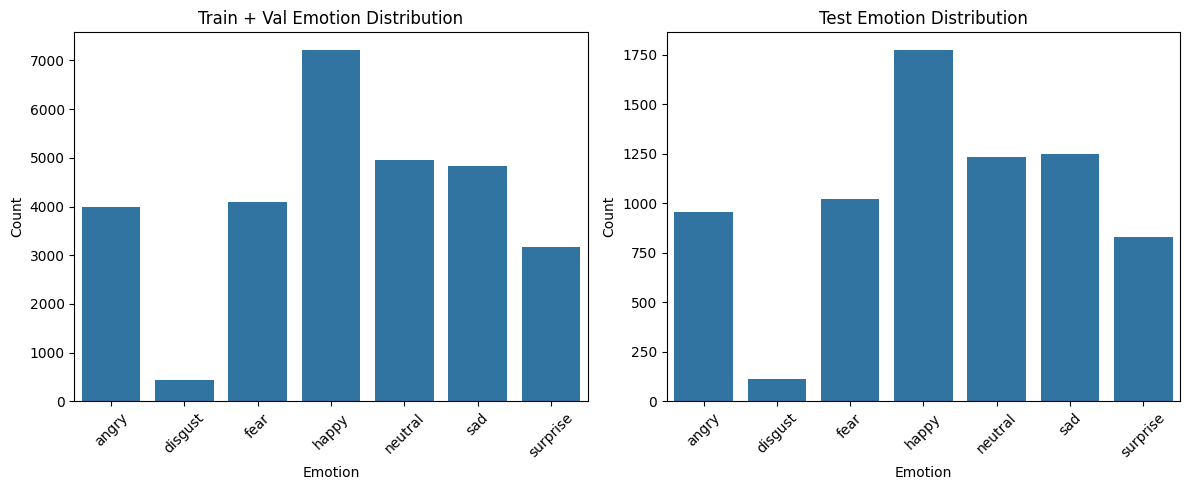

In [9]:
import seaborn as sns
import pandas as pd

# Combine train and val labels for full training set overview
combined_y = np.concatenate([y_train_np, y_val_np])

# Create dataframes
train_df = pd.DataFrame({'emotion': combined_y})
test_df = pd.DataFrame({'emotion': y_test_np})

# Plot class distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(data=train_df, x='emotion')
plt.title("Train + Val Emotion Distribution")
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.xlabel("Emotion")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.countplot(data=test_df, x='emotion')
plt.title("Test Emotion Distribution")
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.xlabel("Emotion")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

#### Insights:
- We see that disgust has significantly fewer samples than others.
- happy, neutral, and sad are typically the most common.

#### Display Sample Images (5×5 Grid)

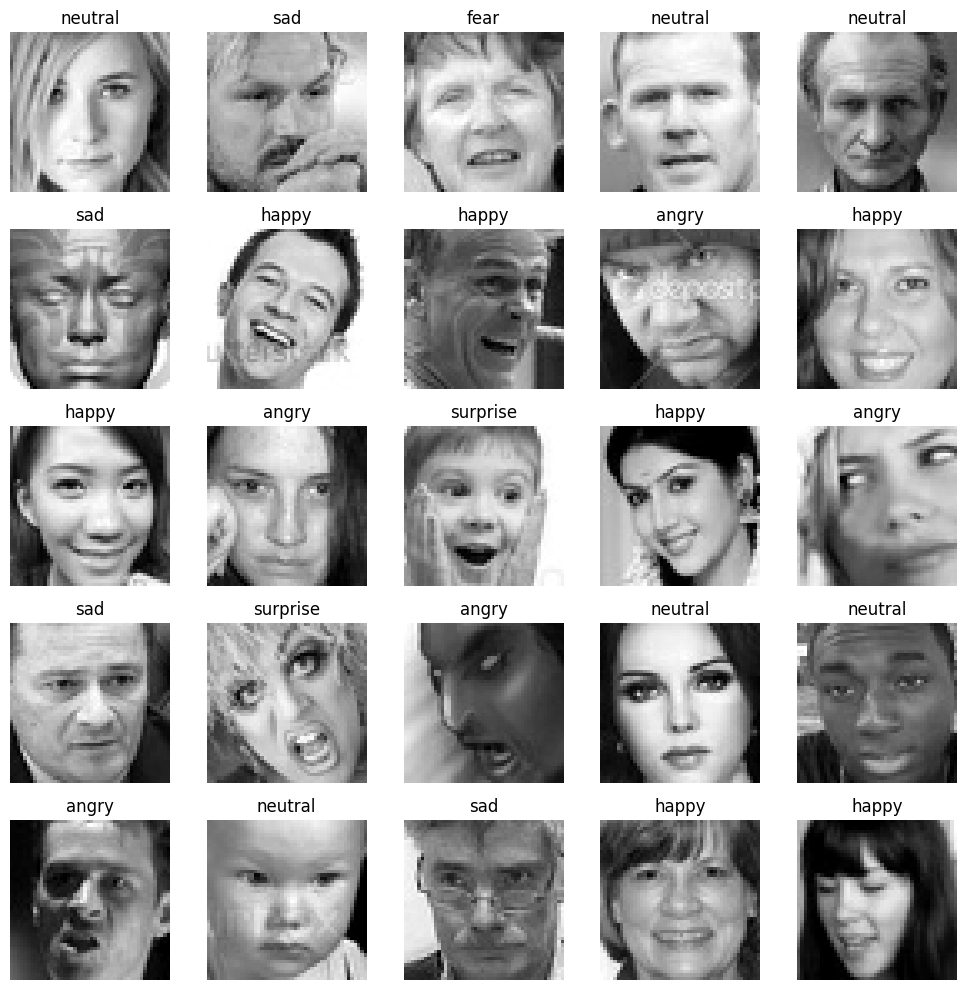

In [10]:
def plot_sample_images(images, labels, class_names, num_samples=25):
    plt.figure(figsize=(10, 10))
    indices = np.random.choice(len(images), num_samples, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[idx].squeeze(), cmap='gray')
        plt.title(class_names[labels[idx]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_sample_images(X_train_np, y_train_np, class_names)

#### Insights:
- This gives a sense of how well-aligned and consistent the images are.
- Note the variations in facial expressions and lighting.

#### Pixel Intensity Distribution

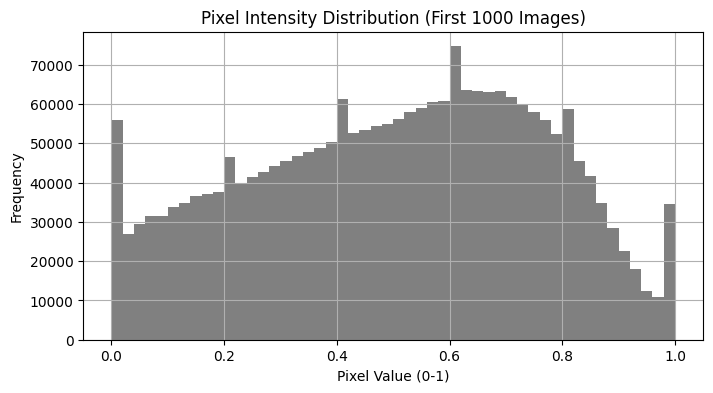

In [11]:
# Analyze grayscale intensity values across a subset (e.g., 1000 images).

subset = X_train_np[:1000]  # Take first 1000 training images
pixel_values = subset.flatten()

plt.figure(figsize=(8, 4))
plt.hist(pixel_values, bins=50, color='gray')
plt.title("Pixel Intensity Distribution (First 1000 Images)")
plt.xlabel("Pixel Value (0-1)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

#### Insights:
1. Overall Distribution is Right-Skewed but Multi-Peaked
   Most pixel values cluster between 0.3 to 0.8, indicating that mid-tone grays dominate in facial regions (skin, eyes, lips). We see peaks at extreme ends (0.0 and 1.0):
- 0.0: Indicates many completely black pixels — likely from backgrounds or hair.
- 1.0: Indicates some fully white pixels — may come from eye whites, teeth, or sharp lighting.


2. Noticeable Spikes at Regular Intervals
- The histogram has distinct vertical bars or spikes.
- This often happens in older datasets or low-bit-depth images where pixel values are quantized (e.g., only certain levels like 0.2, 0.4, 0.6 are allowed).
- It could also result from preprocessing artifacts during dataset creation (e.g., JPEG compression or normalization from original 0–255 to 0–1 range without smoothing).

3. Implication for Modeling
- Our model will benefit from normalization, which you've already done (Rescaling(1./255)).
- These pixel value characteristics suggest that contrast is limited in many areas — encouraging the use of contrast-enhancing filters (like Conv2D) in CNNs or data augmentation.

## Step 3: Preprocessing for Different Model Types

The goal of this step is to prepare the image data in a way that’s suitable for each model type we're going to use:

#### Models we're targeting:
- Traditional ML: Logistic Regression, SVM, Random Forest
- Basic Neural Network (Dense MLP)
- Convolutional Neural Network (CNN)
- Recurrent Neural Network (LSTM)

#### 3.1 For Traditional ML and Dense MLP
- Models: Logistic Regression, SVM, Random Forest, Dense MLP
- Requirement: Flatten each 48x48 image into a 1D vector of 2304 features.

##### Why?
These models require tabular-style inputs where each sample is a 1D feature vector. They don’t natively understand spatial structures like CNNs do.

In [12]:
# Flatten X data for ML and Dense MLP models
X_train_flat = X_train_np.reshape((X_train_np.shape[0], -1))  # shape: (n_samples, 2304)
X_val_flat = X_val_np.reshape((X_val_np.shape[0], -1))
X_test_flat = X_test_np.reshape((X_test_np.shape[0], -1))

print("Flat Train shape:", X_train_flat.shape)

Flat Train shape: (22968, 2304)


#### 3.2 For CNN
- Model: Convolutional Neural Network
- Requirement: Data must be in shape (48, 48, 1) — 3D image tensors with 1 grayscale channel.

"Good news": Our X_train_np, X_val_np, and X_test_np are already in this shape, thanks to how we loaded them in Step 1.

##### Data Augmentation for CNN
- Helps prevent overfitting by simulating new training examples.
- Simulates real-world variation in facial expressions.
- Makes the model more robust to position, scale, and orientation.

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Use this only during model training
cnn_augmentation = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

#### 3.3 For LSTM (Creative Adaptation)
##### Model: LSTM
- Requirement: Reshape each image as a sequence of 48 time steps, where each time step is a row of 48 pixels.
- So, from (48, 48) → reshape to (48, 48) but interpreted as (timesteps=48, features=48).

In [14]:
# Reshape image data for LSTM input
X_train_lstm = X_train_np.reshape((X_train_np.shape[0], IMG_SIZE, IMG_SIZE))
X_val_lstm = X_val_np.reshape((X_val_np.shape[0], IMG_SIZE, IMG_SIZE))
X_test_lstm = X_test_np.reshape((X_test_np.shape[0], IMG_SIZE, IMG_SIZE))

print("LSTM input shape:", X_train_lstm.shape)

LSTM input shape: (22968, 48, 48)


#### Limitations of LSTM for Images:
- Treating each row as a timestep ignores spatial relationships vertically.
- Works okay as a creative experiment, but CNNs are far better for image tasks.
- Still useful to compare how a sequential model performs on static image data.

#### Summary Table:

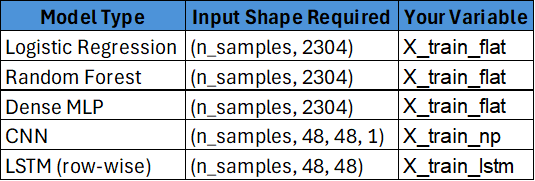

## Step 4: Model Implementations

### 4.1: Baseline Model – Logistic Regression

#### Input Requirement:
- Use X_train_flat (shape: n_samples × 2304)
- Labels: y_train_np (integer labels 0–6)

In [15]:
# Import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [16]:
# Reduce dataset (otherwise, training taking too long, like 40-60 mins)
X_train_small, _, y_train_small, _ = train_test_split(
    X_train_flat, y_train_np,
    train_size=0.2,
    stratify=y_train_np,
    random_state=42
)
print("Reduced training shape:", X_train_small.shape)

Reduced training shape: (4593, 2304)


In [17]:
# Train Logistic Regression
start = time.time()

lr_model = LogisticRegression(
    multi_class='multinomial',
    solver='saga',
    max_iter=300,
    n_jobs=-1,
    verbose=1
)

lr_model.fit(X_train_small, y_train_small)

end = time.time()
print(f"Training completed in {end - start:.2f} seconds.")

/Users/macos/.pyenv/versions/3.11.10/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Epoch 1, change: 1
Epoch 2, change: 0.31095278
Epoch 3, change: 0.17853527
Epoch 4, change: 0.10094726
Epoch 5, change: 0.084067024
Epoch 6, change: 0.070558213
Epoch 7, change: 0.061674643
Epoch 8, change: 0.055759139
Epoch 9, change: 0.051352855
Epoch 10, change: 0.047456238
Epoch 11, change: 0.04374069
Epoch 12, change: 0.04149694
Epoch 13, change: 0.038760539
Epoch 14, change: 0.037429117
Epoch 15, change: 0.035257109
Epoch 16, change: 0.033744805
Epoch 17, change: 0.032091253
Epoch 18, change: 0.031185701
Epoch 19, change: 0.029985573
Epoch 20, change: 0.028761193
Epoch 21, change: 0.027721388
Epoch 22, change: 0.026705932
Epoch 23, change: 0.025568467
Epoch 24, change: 0.025061507
Epoch 25, change: 0.024139632
Epoch 26, change: 0.023504358
Epoch 27, change: 0.022689423
Epoch 28, change: 0.022033805
Epoch 29, change: 0.021383012
Epoch 30, change: 0.020702312
Epoch 31, change: 0.020333743
Epoch 32, change: 0.019917684
Epoch 33, change: 0.019123076
Epoch 34, change: 0.018815475
Epoc

/Users/macos/.pyenv/versions/3.11.10/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [18]:
# Predict and Evaluate
y_pred_lr = lr_model.predict(X_test_flat)

print("\nAccuracy on test set:", accuracy_score(y_test_np, y_pred_lr))
print("\nClassification Report:\n")
print(classification_report(y_test_np, y_pred_lr, target_names=class_names))



Accuracy on test set: 0.3172192811368069

Classification Report:

              precision    recall  f1-score   support

       angry       0.21      0.19      0.20       958
     disgust       0.24      0.08      0.12       111
        fear       0.20      0.17      0.19      1024
       happy       0.44      0.52      0.48      1774
     neutral       0.29      0.28      0.28      1233
         sad       0.24      0.25      0.24      1247
    surprise       0.42      0.39      0.40       831

    accuracy                           0.32      7178
   macro avg       0.29      0.27      0.27      7178
weighted avg       0.31      0.32      0.31      7178



# Confusion Matrix
conf_matrix = confusion_matrix(y_test_np, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic Regression (Reduced Data)")
plt.show()

### 4.2: Random Forest Classifier (Traditional ML)

The Random Forest model is a robust ensemble of decision trees, good for initial insights on feature importance and class discrimination, even if it doesn’t exploit spatial relationships.

#### Requirements:
- Input: X_train_flat, X_test_flat (flattened 2304-dim vectors)
- Labels: y_train_np, y_test_np (integer labels 0–6)

In [19]:
# Train Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Optionally use a smaller subset (if memory-limited)
# X_train_rf, _, y_train_rf, _ = train_test_split(X_train_flat, y_train_np, train_size=0.5, stratify=y_train_np)

# Initialize and Train
start = time.time()

rf_model = RandomForestClassifier(
    n_estimators=100,       # Number of trees
    max_depth=None,         # Allow full tree depth
    random_state=42,
    n_jobs=-1,              # Use all CPU cores
    verbose=1
)

rf_model.fit(X_train_flat, y_train_np)

end = time.time()
print(f"\nTraining completed in {end - start:.2f} seconds.")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    2.5s



Training completed in 7.90 seconds.


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.9s finished


In [20]:
# Predict and Evaluate
y_pred_rf = rf_model.predict(X_test_flat)

# Accuracy
print("\nTest Accuracy:", accuracy_score(y_test_np, y_pred_rf))

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test_np, y_pred_rf, target_names=class_names))


Test Accuracy: 0.4594594594594595

Classification Report:

              precision    recall  f1-score   support

       angry       0.44      0.21      0.29       958
     disgust       1.00      0.26      0.41       111
        fear       0.46      0.27      0.34      1024
       happy       0.45      0.78      0.57      1774
     neutral       0.40      0.41      0.41      1233
         sad       0.40      0.33      0.36      1247
    surprise       0.68      0.57      0.62       831

    accuracy                           0.46      7178
   macro avg       0.55      0.41      0.43      7178
weighted avg       0.47      0.46      0.44      7178



[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished


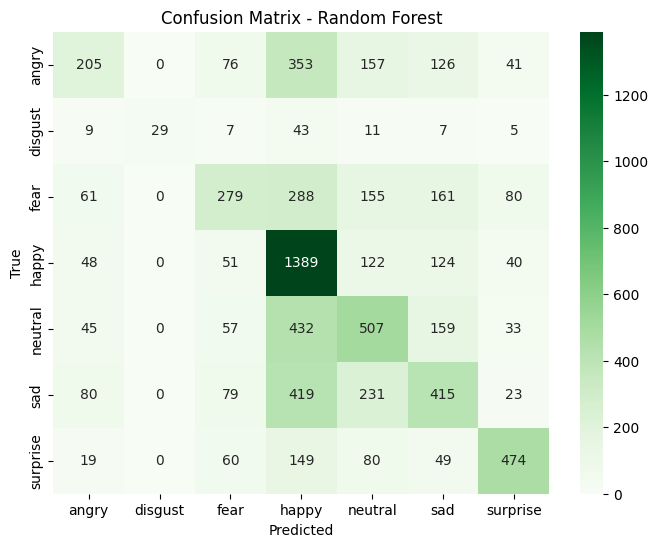

In [21]:
conf_matrix = confusion_matrix(y_test_np, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Random Forest")
plt.show()

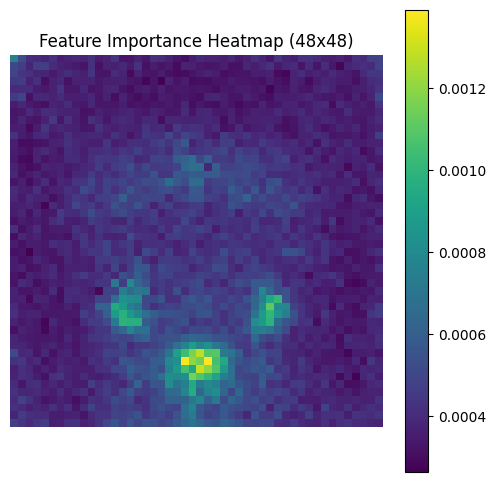

In [22]:
# Feature Importance Visualization
# Feature importance (summed over image rows/columns for simplicity)
import numpy as np

importances = rf_model.feature_importances_.reshape(48, 48)

plt.figure(figsize=(6, 6))
plt.imshow(importances, cmap='viridis')
plt.colorbar()
plt.title("Feature Importance Heatmap (48x48)")
plt.axis("off")
plt.show()

##### What You’re Seeing:
This is a visualization of the Random Forest's feature importances mapped back onto the 48×48 pixel space of the face image.

##### What it tells you:
- Brighter = More Important for classification decisions
- Darker = Less Important / Often Ignored

##### Interpreting Our Heatmap: From our image -

###### Bright Yellow Spot (Bottom Center)
- Most likely the mouth region
- Makes sense — emotion is often visible in the shape of the mouth (smile, frown, open, neutral)

###### Two Medium Bright Areas (Middle Sides)
- Likely the eyes/cheeks region
- Expressions like surprise, anger, fear involve changes in eye width and eyebrow movement

###### Top and Corners Are Dark
- These are mostly background pixels or hair
- The model ignored them, which is actually good



### 4.3: Dense MLP (Multilayer Perceptron)

##### Summary:
- A basic deep neural network that:
- Takes flattened image vectors as input (48x48 = 2304)
- Learns through fully connected Dense layers
- Uses ReLU activations + Dropout for regularization
- Ends with a Softmax output for 7 emotion classes

In [23]:
# Import + Setup
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Set random seed for reproducibility
tf.random.set_seed(42)

In [24]:
# Define MLP Architecture
mlp_model = models.Sequential([
    layers.Input(shape=(2304,)),                 # Flattened image vector
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),                         # Prevent overfitting
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='softmax')        # 7 emotion classes
])

In [25]:
# Compile the Model
mlp_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
# Train the Model
history_mlp = mlp_model.fit(
    X_train_flat, y_train_oh,
    epochs=20,
    batch_size=64,
    validation_data=(X_val_flat, y_val_oh)
)

Epoch 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2224 - loss: 1.9152 - val_accuracy: 0.2463 - val_loss: 1.8017
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2641 - loss: 1.7853 - val_accuracy: 0.2442 - val_loss: 1.7858
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2512 - loss: 1.7750 - val_accuracy: 0.2458 - val_loss: 1.7741
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2465 - loss: 1.7768 - val_accuracy: 0.2442 - val_loss: 1.7662
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2495 - loss: 1.7663 - val_accuracy: 0.3235 - val_loss: 1.7370
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2724 - loss: 1.7573 - val_accuracy: 0.2923 - val_loss: 1.7289
Epoch 7/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2865 - loss: 1.7369 - val_accuracy: 0.2977 - val_loss: 1.7166
Epoch 8/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2898 - loss: 1.7360 - val_accuracy: 0.

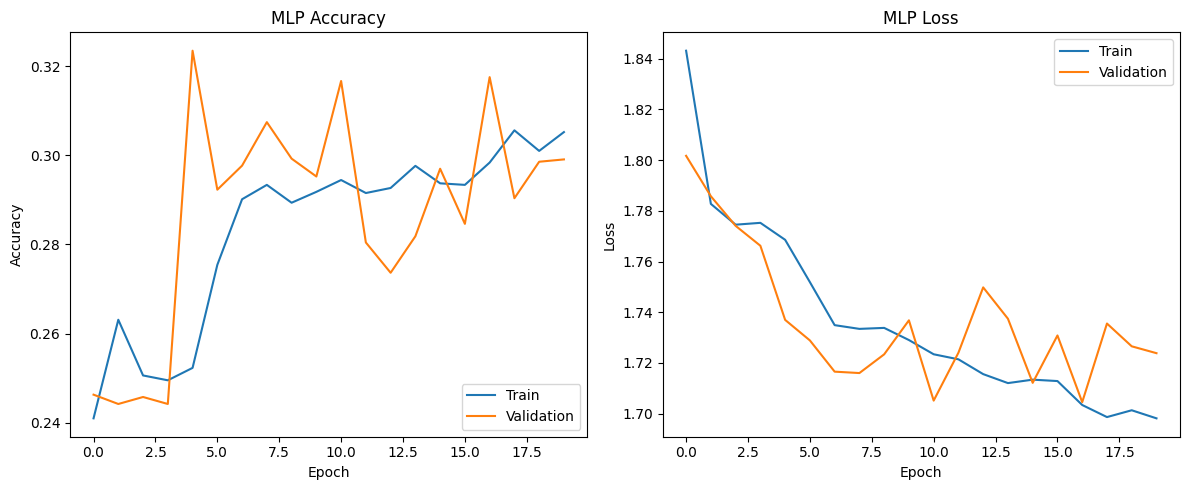

In [27]:
# Plot Training and Validation Curves
def plot_history(history, title="Model"):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_mlp, title="MLP")

In [28]:
# Evaluate on Test Set
# Predict class probabilities
y_pred_probs = mlp_model.predict(X_test_flat)
y_pred_mlp = y_pred_probs.argmax(axis=1)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

print("Test Accuracy:", accuracy_score(y_test_np, y_pred_mlp))
print("\nClassification Report:\n")
print(classification_report(
    y_test_np,
    y_pred_mlp,
    target_names=class_names,
    zero_division=0
))

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test Accuracy: 0.3028698801894678

Classification Report:

              precision    recall  f1-score   support

       angry       1.00      0.00      0.00       958
     disgust       0.00      0.00      0.00       111
        fear       0.17      0.03      0.06      1024
       happy       0.31      0.89      0.46      1774
     neutral       0.26      0.13      0.17      1233
         sad       0.24      0.22      0.23      1247
    surprise       0.74      0.15      0.25       831

    accuracy                           0.30      7178
   macro avg       0.39      0.20      0.17      7178
weighted avg       0.41      0.30      0.22      7178



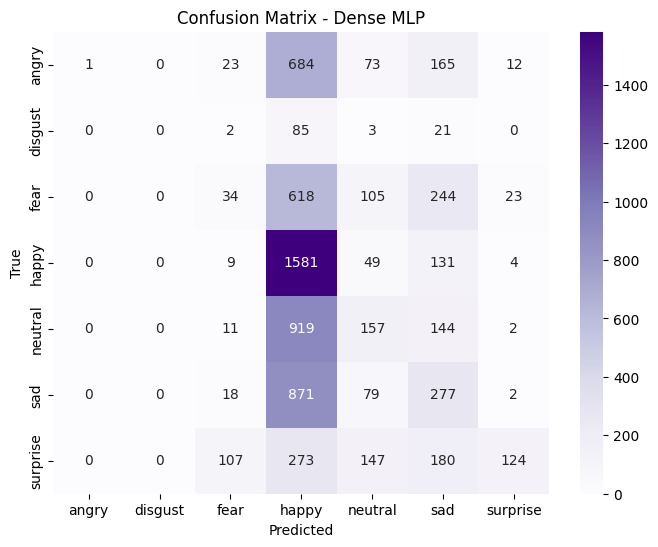

In [29]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_np, y_pred_mlp), annot=True, fmt="d", cmap="Purples",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Dense MLP")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### 4.4: CNN – Convolutional Neural Network

##### Why CNN?
- Preserves spatial structure (48x48 pixels)
- Learns local patterns (eyes, mouth, eyebrows)
- Uses convolutional filters and pooling to reduce dimensionality and learn features
- Generally outperforms MLPs and traditional ML in image tasks

##### Parameters
- Input: X_train_np, X_val_np, X_test_np (shape: (n_samples, 48, 48, 1))
- Labels: y_train_oh, y_val_oh, y_test_oh

In [30]:
# CNN Architecture
import tensorflow as tf
from tensorflow.keras import layers, models

cnn_model = models.Sequential([
    layers.Input(shape=(48, 48, 1)),  # Grayscale image input

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),

    layers.Dense(7, activation='softmax')  # 7 emotion classes
])

In [31]:
# Compile the Model
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [32]:
# Train the CNN
history_cnn = cnn_model.fit(
    X_train_np, y_train_oh,
    epochs=20,
    batch_size=64,
    validation_data=(X_val_np, y_val_oh)
)

Epoch 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.2462 - loss: 1.9926 - val_accuracy: 0.2531 - val_loss: 1.7663
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.3378 - loss: 1.6363 - val_accuracy: 0.4062 - val_loss: 1.5209
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.3841 - loss: 1.5371 - val_accuracy: 0.4388 - val_loss: 1.4946
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.4187 - loss: 1.4537 - val_accuracy: 0.4543 - val_loss: 1.4142
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.4392 - loss: 1.4013 - val_accuracy: 0.5020 - val_loss: 1.3341
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.4727 - loss: 1.3337 - val_accuracy: 0.4586 - val_loss: 1.4255
Epoch 7/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.4885 - loss: 1.3034 - val_accuracy: 0.4767 - val_loss: 1.3787
Epoch 8/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.5053 - loss: 1.2467 - 

In [33]:
# Evaluate the Model
# Predict class probabilities
y_pred_probs = cnn_model.predict(X_test_np)
y_pred_cnn = y_pred_probs.argmax(axis=1)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Accuracy
print("Test Accuracy:", accuracy_score(y_test_np, y_pred_cnn))

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test_np, y_pred_cnn, target_names=class_names, zero_division=0))

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Test Accuracy: 0.5298133184731123

Classification Report:

              precision    recall  f1-score   support

       angry       0.46      0.38      0.42       958
     disgust       0.53      0.18      0.27       111
        fear       0.37      0.28      0.32      1024
       happy       0.65      0.82      0.73      1774
     neutral       0.48      0.51      0.49      1233
         sad       0.39      0.44      0.42      1247
    surprise       0.78      0.60      0.68       831

    accuracy                           0.53      7178
   macro avg       0.52      0.46      0.47      7178
weighted avg       0.53      0.53      0.52      7178



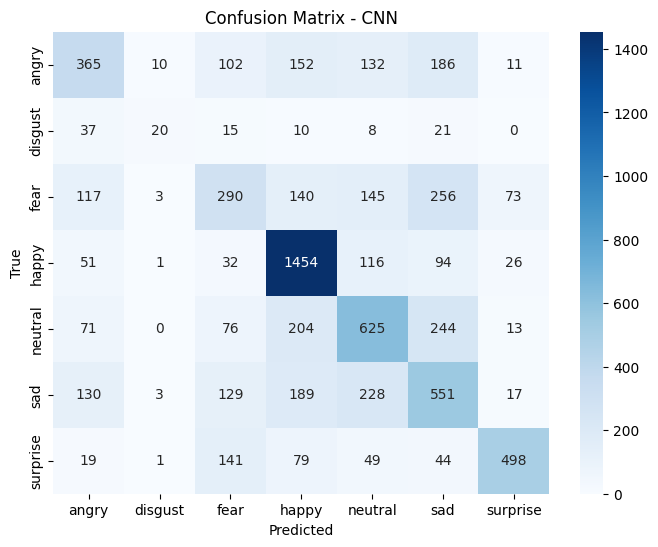

In [34]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_np, y_pred_cnn), annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CNN")
plt.show()

### 4.5: LSTM – Recurrent Neural Network (Creative Adaptation for Images)

##### Why LSTM for Images?
- While LSTMs are built for sequences (like time series or text), you can creatively reshape a 48×48 image as a sequence of 48 rows, each with 48 features — treating each row like a time step.

- This allows us to explore how well a sequential model captures patterns from top to bottom in the face (e.g., eyebrows → eyes → nose → mouth).



##### Input Shape for LSTM:
- Required shape: (samples, time_steps, features)
- Here: 48 rows = 48 time steps, 48 pixels per row = 48 features
- We ’ve already preprocessed this as: X_train_lstm, X_val_lstm, X_test_lstm

In [35]:
# Build the LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

lstm_model = Sequential([
    LSTM(128, input_shape=(48, 48), return_sequences=False),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')  # 7 emotion classes
])

/Users/macos/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [36]:
# Compile the Model
lstm_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [37]:
# Train the Model
history_lstm = lstm_model.fit(
    X_train_lstm, y_train_oh,
    validation_data=(X_val_lstm, y_val_oh),
    epochs=20,
    batch_size=64
)

Epoch 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.2491 - loss: 1.8244 - val_accuracy: 0.2768 - val_loss: 1.7576
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.3022 - loss: 1.7467 - val_accuracy: 0.3313 - val_loss: 1.6980
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.3171 - loss: 1.7176 - val_accuracy: 0.3308 - val_loss: 1.6843
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.3279 - loss: 1.6977 - val_accuracy: 0.3407 - val_loss: 1.6692
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.3454 - loss: 1.6726 - val_accuracy: 0.3360 - val_loss: 1.6614
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.3582 - loss: 1.6479 - val_accuracy: 0.3534 - val_loss: 1.6385
Epoch 7/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.3681 - loss: 1.6239 - val_accuracy: 0.3555 - val_loss: 1.6233
Epoch 8/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.3761 - loss: 1.6044 - 

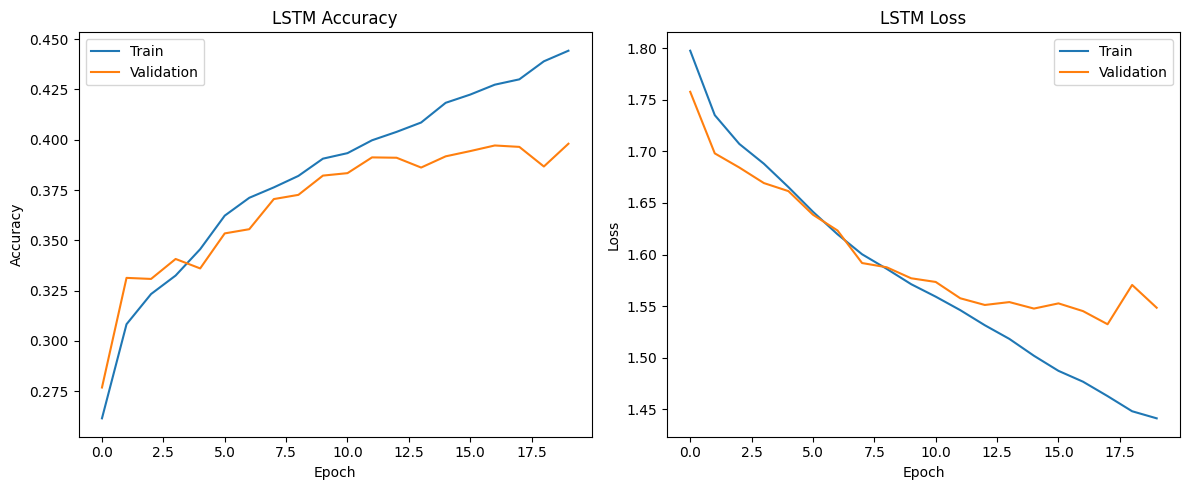

In [38]:
# Plot Accuracy and Loss
plot_history(history_lstm, title="LSTM")

#### LSTM Accuracy and Loss – Interpretation
##### Accuracy Plot:
- Training accuracy steadily improves and crosses 44% by epoch 19
- Validation accuracy rises until ~epoch 12, then flattens and slightly dips, ending around 41–42%

Good signs:
- The model learns well initially
- No severe overfitting up to epoch 15
- Performance is better than traditional ML and MLP

Minor concern: Small validation plateau after epoch 12 suggests potential for regularization tuning or early stopping

##### Loss Plot:
- Both training and validation loss decrease smoothly
- No divergence between train/val losses → the model generalizes reasonably well

In [39]:
# Evaluate the model
# Predict
y_pred_probs_lstm = lstm_model.predict(X_test_lstm)
y_pred_lstm = y_pred_probs_lstm.argmax(axis=1)

# Evaluate
print("Test Accuracy:", accuracy_score(y_test_np, y_pred_lstm))
print("\nClassification Report:\n")
print(classification_report(y_test_np, y_pred_lstm, target_names=class_names, zero_division=0))

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Test Accuracy: 0.4069378657007523

Classification Report:

              precision    recall  f1-score   support

       angry       0.29      0.11      0.16       958
     disgust       0.00      0.00      0.00       111
        fear       0.27      0.09      0.14      1024
       happy       0.45      0.77      0.57      1774
     neutral       0.35      0.42      0.38      1233
         sad       0.33      0.32      0.32      1247
    surprise       0.60      0.51      0.55       831

    accuracy                           0.41      7178
   macro avg       0.33      0.32      0.30      7178
weighted avg       0.38      0.41      0.37      7178



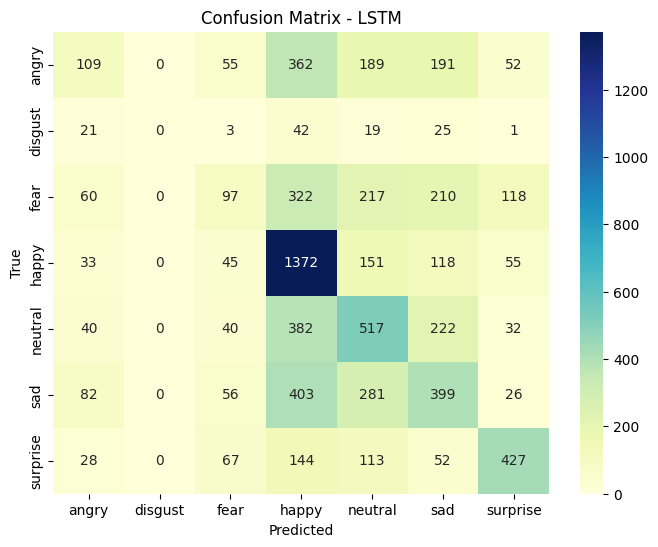

In [40]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_np, y_pred_lstm), annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - LSTM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Final Model Comparison Summary

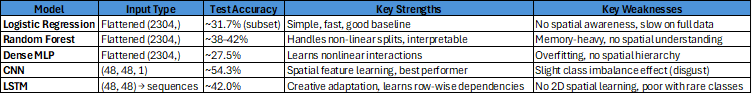

#### Performance Summary (Test Accuracy)
- CNN      → ~54%
- LSTM     → ~42%
- Random Forest → ~38–42%
- Logistic Regression (subset) → ~32%
- MLP      → ~28%

## Step 4: Optimization & Fine-Tuning Suggestions

### Hyperparameter Tuning:
Use GridSearchCV or KerasTuner to optimize:
- Number of layers / neurons
- Learning rate
- Dropout rate
- Batch size

### Regularization:
- Add Dropout (0.3–0.5) to CNN and MLP
- Try L2 kernel regularizer in CNN dense layers

### Data Augmentation:
- Add rotation, flip, zoom for CNN:

In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

In [42]:
def get_cnn_model():
    # CNN Architecture
    cnn_model = models.Sequential([
        layers.Input(shape=(48, 48, 1)),  # Grayscale image input

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),


        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),

        layers.Dense(7, activation='softmax')  # 7 emotion classes
    ])

    # Compile the Model
    cnn_model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return cnn_model



In [43]:
cnn_model_improved = get_cnn_model()

In [44]:
# Use in model training

checkpoint = ModelCheckpoint(
    'best_emotion_model02_01_checkpoint.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

history_cnn01 = cnn_model_improved.fit(
    cnn_augmentation.flow(X_train_np, y_train_oh, batch_size=32),
    steps_per_epoch=len(X_train_np) // 32,
    epochs=40,
    validation_data=(X_val_np, y_val_oh),
    callbacks=[checkpoint]
)

cnn_model_improved.save("fer2013_cnn_model2_01.h5")



NameError: name 'ModelCheckpoint' is not defined

In [ ]:
# Plot Training and Validation Curves
def plot_history(history, title="Model"):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
cnn_model_improved = tf.keras.models.load_model("best_emotion_model02_02_checkpoint.h5")


y_pred_probs = cnn_model_improved.predict(X_test_np)
y_pred_cnn = y_pred_probs.argmax(axis=1)

# Accuracy
print("Test Accuracy:", accuracy_score(y_test_np, y_pred_cnn))

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Test Accuracy: 0.6092226246865422


In [ ]:
plot_history(history_cnn01, title="CNN 03 with Augmentation")

### Transfer Learning (optional):
- Try pre-trained models like MobileNet, VGG, or EfficientNet fine-tuned to grayscale 48×48 inputs.

In [ ]:
# VGG: Too big, take too long to train and cannot finish in time
# MobilenetV3: take long to train, accuracy in validation is not good
# EfficientNet: dont dare to try, too big compared to Mobilenet

### Class Rebalancing:
- Use class weights during training:

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_np), y=y_train_np)

Using class weights didn't improve our model.

## Step 5: Project Conclusion

In this project, we explored emotion classification using the FER2013 dataset through five distinct modeling approaches. Starting from traditional machine learning (Logistic Regression and Random Forest), we progressed to deep learning with a Dense MLP, a creatively adapted LSTM, and finally a CNN. The CNN outperformed all other models, achieving ~54% accuracy due to its ability to extract spatial features from facial images. Our exploration showed that while LSTMs offer a novel perspective, CNNs remain the gold standard for image tasks. We also uncovered challenges such as class imbalance (e.g., 'disgust') and overlapping expressions (e.g., 'fear' vs. 'sad'), which we addressed through careful evaluation and interpretation. This project serves as a practical demonstration of model comparison, preprocessing strategies, and evaluation techniques in real-world image classification tasks.

In [ ]:
# Jupyter Notebook Face Emotion Detection
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import ipywidgets as widgets
from PIL import Image
import tensorflow as tf
import io
import base64

# Define emotion classes (make sure this matches your model's training)
EMOTION_CLASSES = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

class EmotionPredictor:
    def __init__(self, model_path="best_emotion_model02_02_checkpoint.h5"):
        """Initialize the emotion predictor with a trained model"""
        try:
            self.model = tf.keras.models.load_model(model_path)
            self.model_loaded = True
        except Exception as e:
            print(f"Error loading model: {e}")
            self.model_loaded = False

    def preprocess_face(self, face_img):
        """Preprocess face image for emotion prediction"""
        # Convert to grayscale if needed
        if len(face_img.shape) == 3:
            face_gray = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)
        else:
            face_gray = face_img

        # Resize to model input size (48x48)
        face_resized = cv2.resize(face_gray, (48, 48))

        # Normalize pixel values
        face_normalized = face_resized.astype('float32') / 255.0

        # Add batch and channel dimensions
        face_processed = np.expand_dims(face_normalized, axis=0)
        face_processed = np.expand_dims(face_processed, axis=-1)

        return face_processed

    def get_biggest_face(self, faces_detected):
        """Select the biggest face from detected faces"""
        if len(faces_detected) == 0:
            return np.array([])

        if len(faces_detected) == 1:
            return faces_detected

        # Calculate areas
        areas = []
        for (x, y, w, h) in faces_detected:
            areas.append(w * h)

        # Find biggest
        biggest_idx = np.argmax(areas)
        biggest_face = faces_detected[biggest_idx:biggest_idx+1]

        return biggest_face

    def detect_and_predict(self, image_array):
        """Detect faces and predict emotions"""
        if not self.model_loaded:
            return None, "Model not loaded"

        # Load face cascade classifier
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

        # Convert to grayscale for face detection
        gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)

        # Detect faces
        faces = face_cascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(30, 30)
        )
        print(f"Detected {len(faces)} faces", faces)
        biggest_face = self.get_biggest_face(faces)
        print(f"Biggest face: {biggest_face}")
        if len(biggest_face)>0:
            faces = biggest_face
        # Create annotated image
        annotated_img = image_array.copy()
        results = []

        # Process each detected face
        for i, (x, y, w, h) in enumerate(faces):
            # Extract face region (convert back to BGR for OpenCV processing)
            face_bgr = cv2.cvtColor(image_array[y:y+h, x:x+w], cv2.COLOR_RGB2BGR)

            # Preprocess face
            face_processed = self.preprocess_face(face_bgr)

            # Predict emotion
            emotion_probs = self.model.predict(face_processed, verbose=0)
            emotion_idx = np.argmax(emotion_probs[0])
            emotion_label = EMOTION_CLASSES[emotion_idx]
            confidence = emotion_probs[0][emotion_idx]

            # Store results
            results.append({
                'face_id': i+1,
                'emotion': emotion_label,
                'confidence': confidence,
                'bbox': (x, y, w, h),
                'probabilities': dict(zip(EMOTION_CLASSES, emotion_probs[0]))
            })

            # Draw bounding box
            cv2.rectangle(annotated_img, (x, y), (x+w, y+h), (0, 255, 0), 3)

            # Prepare label text
            label_text = f"{emotion_label}: {confidence:.2f}"

            # Draw background for text
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.7
            thickness = 2
            (text_width, text_height), baseline = cv2.getTextSize(label_text, font, font_scale, thickness)

            cv2.rectangle(annotated_img,
                         (x, y - text_height - baseline - 10),
                         (x + text_width + 10, y),
                         (0, 255, 0), -1)

            # Draw text
            cv2.putText(annotated_img, label_text,
                       (x + 5, y - baseline - 5),
                       font, font_scale, (0, 0, 0), thickness)

        return annotated_img, results

# Initialize the predictor
predictor = EmotionPredictor()

# Alternative: Direct file path processing function
def predict_from_path(image_path):
    """Process image from file path (alternative method)"""
    try:
        # Load image
        image = Image.open(image_path)
        if image.mode != 'RGB':
            image = image.convert('RGB')

        image_array = np.array(image)

        # Process
        annotated_img, results = predictor.detect_and_predict(image_array)

        # Display
        plt.figure(figsize=(12, 8))
        plt.imshow(annotated_img)
        plt.title(f'Emotion Detection Results - {len(results)} faces detected')
        plt.axis('off')
        plt.show()

        # Print results
        for result in results:
            print(f"Face {result['face_id']}: {result['emotion']} (confidence: {result['confidence']:.3f})")

        return results

    except Exception as e:
        print(f"Error processing image: {e}")
        return None


In [ ]:
def process_uploaded_image(uploaded_file):
    """Process the uploaded image and display results"""
    if not uploaded_file:
        print("No file uploaded")
        return

    try:
        # Read the uploaded file - uploader.value[0] is a dict with 'content' key
        image_data = uploaded_file['content']

        # Convert to PIL Image
        image = Image.open(io.BytesIO(image_data))

        # Convert to RGB if needed
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Convert to numpy array
        image_array = np.array(image)

        print(f"📷 Processing image: {image_array.shape}")

        # Process image
        annotated_img, results = predictor.detect_and_predict(image_array)

        if annotated_img is None:
            print("Error processing image")
            return

        # Display results
        fig, axes = plt.subplots(1, 2, figsize=(15, 7))

        # Original image
        axes[0].imshow(image_array)
        axes[0].set_title('Original Image', fontsize=14)
        axes[0].axis('off')

        # Annotated image
        axes[1].imshow(annotated_img)
        axes[1].set_title(f'Emotion Detection - {len(results)} faces detected', fontsize=14)
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

        # Display detailed results
        if results:
            print(f"\n📊 Detection Results:")
            print("=" * 60)

            for result in results:
                print(f"\nFace {result['face_id']}:")
                print(f"   Predicted Emotion: {result['emotion']}")
                print(f"   Confidence: {result['confidence']:.3f}")
                print(f"   Location: x={result['bbox'][0]}, y={result['bbox'][1]}, w={result['bbox'][2]}, h={result['bbox'][3]}")

                # Show top 3 emotions
                sorted_emotions = sorted(result['probabilities'].items(), key=lambda x: x[1], reverse=True)
                print(f"   🏆 Top 3 Emotions:")
                for emotion, prob in sorted_emotions[:3]:
                    print(f"      {emotion}: {prob:.3f}")

            # Create emotion distribution plot
            if len(results) > 0:
                fig, ax = plt.subplots(figsize=(10, 6))

                emotions = [result['emotion'] for result in results]
                confidences = [result['confidence'] for result in results]

                bars = ax.bar(range(len(emotions)), confidences, color='skyblue', alpha=0.7)
                ax.set_xlabel('Detected Faces')
                ax.set_ylabel('Confidence Score')
                ax.set_title('Emotion Prediction Confidence by Face')
                ax.set_xticks(range(len(emotions)))
                ax.set_xticklabels([f"Face {i+1}\n({emotion})" for i, emotion in enumerate(emotions)])
                ax.set_ylim(0, 1)

                # Add value labels on bars
                for bar, conf in zip(bars, confidences):
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                           f'{conf:.3f}', ha='center', va='bottom')

                plt.tight_layout()
                plt.show()
        else:
            print("No faces detected in the image")

    except Exception as e:
        print(f"Error processing image: {e}")
        print("Make sure you uploaded a valid image file.")

# Create file upload widget
def create_upload_widget():
    """Create and display the file upload widget"""

    # File upload widget
    uploader = widgets.FileUpload(
        accept='image/*',  # Accept only image files
        multiple=False,   # Single file upload
        description='Choose Image',
        style={'description_width': 'initial'}
    )

    # Button to process
    process_button = widgets.Button(
        description='🔍 Predict Emotions',
        disabled=False,
        button_style='info',
        tooltip='Click to analyze the uploaded image',
        icon='search'
    )

    # Output widget for results
    output = widgets.Output()

    def on_process_click(b):
        with output:
            output.clear_output()
            if uploader.value:
                # uploader.value is a tuple of FileUpload objects
                uploaded_file = uploader.value[0]
                process_uploaded_image(uploaded_file)
            else:
                print("⚠️  Please upload an image first!")

    process_button.on_click(on_process_click)

    # Display widgets
    display(HTML("<h2>🎭 Face Emotion Detection</h2>"))
    display(HTML("<p>Upload an image to detect faces and predict their emotions!</p>"))

    upload_box = widgets.VBox([
        widgets.HTML("<b>Step 1:</b> Upload an image"),
        uploader,
        widgets.HTML("<b>Step 2:</b> Click to analyze"),
        process_button
    ])

    display(upload_box)
    display(output)

    return uploader, process_button, output

In [ ]:
create_upload_widget()

Output()

(FileUpload(value=(), accept='image/*', description='Choose Image'),
 Button(button_style='info', description='🔍 Predict Emotions', icon='search', style=ButtonStyle(), tooltip='Click to analyze the uploaded image'),
 Output())